In [5]:
import itertools

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from estimagic.differentiation.derivatives import first_derivative

In [16]:
def visualize_derivative(
    df_evals,
    df_jac_cand,
    func_value,
    params,
    dim_x=None,
    dim_f=None,
    height=5,
    width=5,
    grid_points=50,
):
    """Plot evaluations and derivative estimates.

    The resulting grid plot displays function evaluations and derivatives. The derivatives
    are visualized as the Taylor approximation. Bands are drawn indicating the area in
    which forward and backward derivatives should be located. These bands are not to be
    confused with error bands. We simply fill the area when using the naive
    [forward / backward] estimate when using 1 step vs. using maximum number of steps.

    Args:
        df_evals (pd.DataFrame): Frame containing func evaluations (long-format).
        df_jac_cand (pd.DataFrame): Frame containing jacobian candidates (long-format).
        func_value (np.ndarray): Func value at original params vector.
        params (np.ndarray): Params vector.
        dim_x (iterable): Input dimension to consider. Default None, which selects all.
        dim_f (iterable): Output dimensions to consider. Default None, which selects all.
        height (float): Height of represenative plot in grid.
        width (float): Width of representative plot in grid.
        grid_points (int): Number of grid points used for plotting x-axis. Default 50.

    Returns:
        grid (sns.FacetGrid): Plot.

    """
    sns.set_style("whitegrid")
    
    df = df_evals.reset_index()
    df = df.assign(**{"step": df.step * df.sign})
    df_evals = df.set_index(["sign", "step_number", "dim_x", "dim_f"])

    dimensions = df[["dim_x", "dim_f"]].max()
    dim_x = dim_x if dim_x is not None else range(dimensions["dim_x"] + 1)
    dim_f = dim_f if dim_f is not None else range(dimensions["dim_f"] + 1)
    df = df.query("dim_x in @dim_x & dim_f in @dim_f")

    # prepare derivative data
    method_minimizer = df_jac_cand.groupby(["method", "dim_x", "dim_f"])["err"].idxmin()
    minimizer = df_jac_cand.groupby(["dim_x", "dim_f"])["err"].idxmin()

    der_method = df_jac_cand.loc[method_minimizer]["der"].droplevel("num_term")
    der = df_jac_cand.loc[minimizer]["der"].droplevel(["method", "num_term"])

    # auxiliaries
    func_value = np.atleast_1d(func_value)
    n_steps = df["step_number"].max()
    max_steps = df.groupby("dim_x")["step"].max()
    palette = {
        "returned": "black",
        "forward": "tab:green",
        "central": "tab:blue",
        "backward": "tab:orange",
        1: "green",
        -1: "orange",
    }

    # plot
    grid = sns.FacetGrid(
        df, row="dim_x", col="dim_f", sharey=False, height=height, aspect=width / height
    )
    grid.map(sns.scatterplot, "step", "eval", color="black", label="Func eval")
    grid.set_titles(template="dim_x, dim_f = {row_name}, {col_name}")
    grid.set_axis_labels("Param Value Relative to x0", "Func Value")

    for row, col in itertools.product(dim_x, dim_f):
        y0 = func_value[col]
        x0 = params[row]
        ax = grid.axes[row, col]
        _x = np.linspace(-max_steps[row], max_steps[row], grid_points)

        # draw derivative returned by functionkJ
        _y = y0 + _x * der.loc[row, col]
        ax.plot(
            _x, _y, color=palette["returned"], label="returned", zorder=2, linewidth=2
        )

        # draw optimal derivative given each method
        for method in ["forward", "central", "backward"]:
            _y = y0 + _x * der_method.loc[method, row, col]
            ax.plot(
                _x, _y, color=palette[method], label=method, zorder=1, linewidth=1.5
            )

        # fill area
        for sign in [1, -1]:
            ys = []
            for step in [1, n_steps]:
                diff_x, diff_y = df_evals.loc[sign, step, row, col].values.T - np.array(
                    [0, y0]
                )
                slope = diff_y / diff_x
                _y = y0 + _x * slope
                ys.append(_y)
                ax.plot(_x, _y, "--", color=palette[sign], linewidth=0.5)
            ax.fill_between(_x, ys[0], ys[1], alpha=0.15, color=palette[sign])

        # auxiliary
        if (row, col) == (0, 0):
            ax.legend(loc='upper center', bbox_to_anchor=(len(dim_f) / 2, 1.2), ncol=5)
        ax.set_frame_on(False)

    return grid

### Example

In [7]:
def func(x):
    y1 = (x[0] - 1) ** 2
    y2 = 1 + x[0]
    return np.array([y1, y2])

params = np.ones(3)

In [8]:
n_steps, dim_x, dim_f = 5, len(params), len(func(params))

der, info = first_derivative(
    func,
    params,
    n_steps=n_steps,
    return_func_value=True,
    return_evals=True,
    return_jac_cand=True,
)

func_value = info["func_value"]
df_evals = info["df_evals"]
df_jac_cand = info["df_jac_cand"]

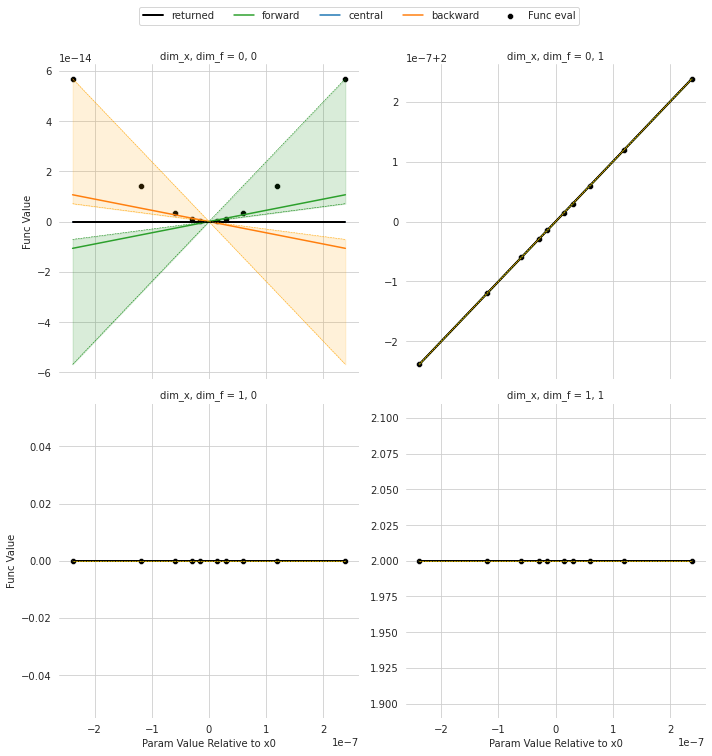

In [19]:
visualize_derivative(df_evals, df_jac_cand, func_value, params, dim_x=[0, 1])